# More with R

### **By [Ryan Menezes](https://twitter.com/ryanvmenezes) (Los Angeles Times)** & [Christine Zhang](https://twitter.com/christinezhang) (Knight-Mozilla / Los Angeles Times)

*IRE conference -- New Orleans, LA*  
 
June 18 2016  

This workshop is a continuation of our previous session, [Getting started with R](Getting%20started%20with%20R.ipynb)

R is a powerful tool that can help you quickly and effectively answer questions using data.

Take our host city, New Orleans, for example:

* Hurricane Katrina was a devastating natural disaster that substantially affected the population of New Orleans.

* The hurricane took place in August 2005, which coincidentally falls between the 2000 and 2010 U.S. Censuses.

* This allows us to measure the effect of the hurricane on the populations of the different areas of New Orleans.

** Here are some questions we will set out to answer: **

* How much did the population of New Orleans change between 2000 and 2010?
* In which census tracts and parishes (Louisiana lingo for counties) did it change the most?
* How did the occupancy of homes change in that time period?

** We will use the Demographic Profiles for both years, downloaded from the [U.S. Census Bureau](http://factfinder.census.gov/faces/nav/jsf/pages/index.xhtml). ** 

** To recap, in Getting started with R, we cleaned and merged two census datasets with some demographic information on Louisiana. **

** In this session, we will: **

* Load in the datasets
* Perform some cleaning of the data
* Select the variables of interest
* Look at the Orleans Parish in particular, which represents New Orleans
* Calculate the percent change in population between 2000 and 2010


In [60]:
census <- read.csv('census_comparison.csv')
head(census)

,fips.code,tract,parish,state,population.00,total.housing.units.00,occupied.housing.units.00,vacant.housing.units.00,population.10,total.housing.units.10,occupied.housing.units.10,vacant.housing.units.10
1,22001960100,Census Tract 9601,Acadia Parish,Louisiana,6188,2410,2236,174,6213,2574,2345,229
2,22001960200,Census Tract 9602,Acadia Parish,Louisiana,5056,1909,1764,145,5988,2362,2144,218
3,22001960300,Census Tract 9603,Acadia Parish,Louisiana,3149,1246,1145,101,3582,1427,1286,141
4,22001960400,Census Tract 9604,Acadia Parish,Louisiana,5617,2176,1991,185,6584,2604,2362,242
5,22001960500,Census Tract 9605,Acadia Parish,Louisiana,4927,1796,1692,104,6093,2349,2178,171
6,22001960600,Census Tract 9606,Acadia Parish,Louisiana,5654,2292,2073,219,5972,2504,2306,198


In [61]:
orleans <- census %>% filter(parish == 'Orleans Parish')
str(orleans)

'data.frame':	211 obs. of  12 variables:
 $ fips.code                : num  2.21e+10 2.21e+10 2.21e+10 2.21e+10 2.21e+10 ...
 $ tract                    : Factor w/ 793 levels "Census Tract 1",..: 1 159 368 453 596 597 598 599 600 601 ...
 $ parish                   : Factor w/ 64 levels "Acadia Parish",..: 36 36 36 36 36 36 36 36 36 36 ...
 $ state                    : Factor w/ 1 level "Louisiana": 1 1 1 1 1 1 1 1 1 1 ...
 $ population.00            : int  2381 1347 1468 2564 2034 2957 2342 5131 2902 4400 ...
 $ total.housing.units.00   : int  1408 691 719 1034 704 1106 978 2100 992 1641 ...
 $ occupied.housing.units.00: int  1145 496 559 873 506 1011 671 1886 893 1593 ...
 $ vacant.housing.units.00  : int  263 195 160 161 198 95 307 214 99 48 ...
 $ population.10            : int  2455 1197 1231 2328 849 2534 1605 3925 2205 4346 ...
 $ total.housing.units.10   : int  1513 738 641 1137 328 1108 922 1795 994 1644 ...
 $ occupied.housing.units.10: int  1229 496 467 911 269 923 498 1456

In [62]:
sum(orleans$population.00)

[1] NA

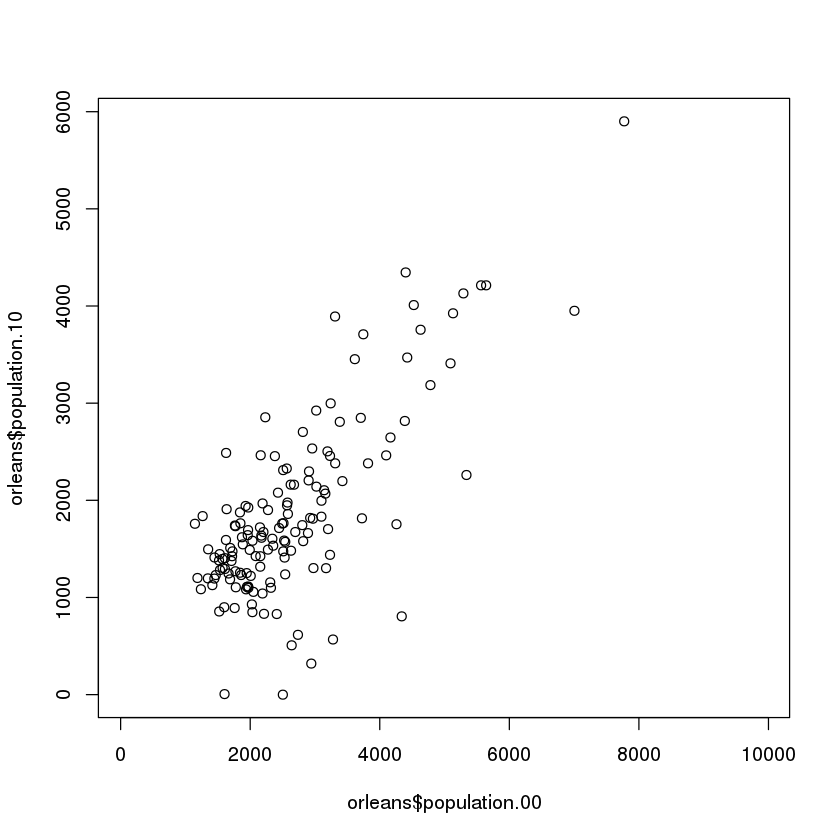

In [63]:
plot(orleans$population.00, orleans$population.10)

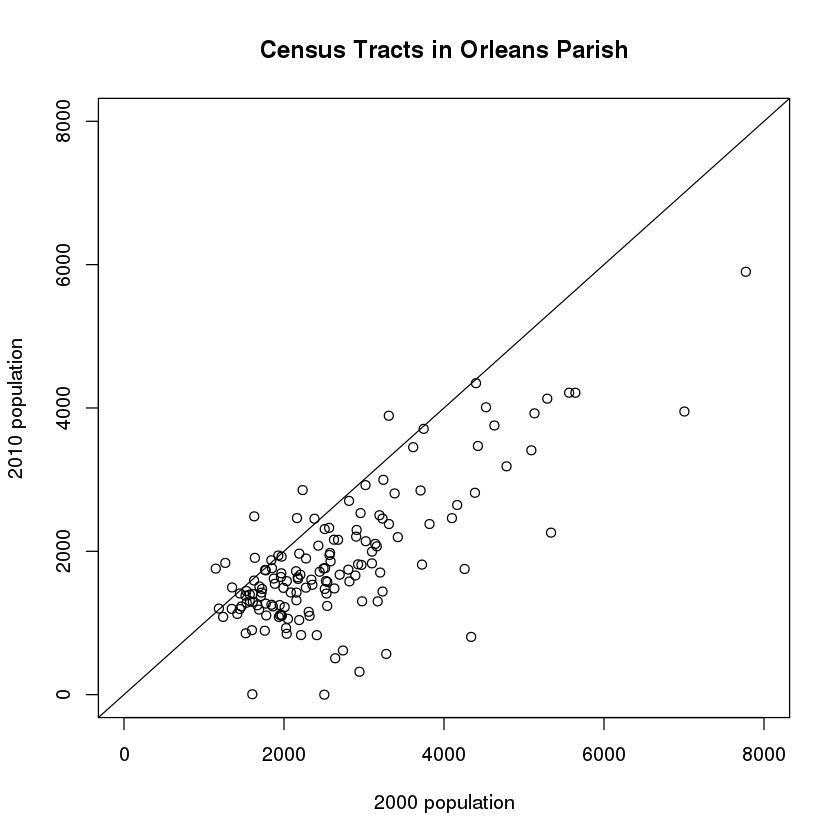

In [64]:
plot(orleans$population.00, orleans$population.10, 
     xlim = c(0, 8000), 
     ylim = c(0, 8000),
     xlab = '2000 population',
     ylab = '2010 population',
     main = 'Census Tracts in Orleans Parish'
     )

abline(0, 1)

In [65]:
orleans$pop.diff <- orleans$population.10 - orleans$population.00

How many tracts in Orleans parish saw population drops between 2000 and 2010?

In [70]:
pop.drops.orleans <- sum(orleans$pop.diff < 0, na.rm = TRUE)

In [71]:
print(paste('In New Orleans,', pop.drops.orleans, 'tracts dropped in population between 2000 and 2010.'))

[1] "In New Orleans, 135 tracts dropped in population between 2000 and 2010."


In [10]:
library('dplyr')

parishes <- census %>% 
group_by(parish) %>%  # this tells R to group our data by parishes
summarise_each( 
    # sum all the columns 
    funs(sum),
    # except the non-numerical ones
    -fips.code, -tract, -state
) 

parishes

,parish,population.00,total.housing.units.00,occupied.housing.units.00,vacant.housing.units.00,population.10,total.housing.units.10,occupied.housing.units.10,vacant.housing.units.10
1,Acadia Parish,58861,23209,21142,2067,61773,25387,22841,2546
2,Allen Parish,25440,9157,8102,1055,25764,9733,8516,1217
3,Ascension Parish,76627,29172,26691,2481,107215,40784,37790,2994
4,Assumption Parish,23388,9635,8239,1396,23421,10351,8736,1615
5,Avoyelles Parish,41481,16576,14736,1840,42073,18042,15432,2610
6,Beauregard Parish,32986,14501,12104,2397,35654,15040,13159,1881
7,Bienville Parish,15752,7830,6108,1722,14353,7718,5838,1880
8,Bossier Parish,72770,30047,27245,2802,82563,34518,31684,2834
9,Caddo Parish,234143,99829,90348,9481,235774,102781,93636,9145
10,Calcasieu Parish,166827,68917,62411,6506,171699,73272,65838,7434


In [75]:
parishes$perc.occupied.00 <- parishes$occupied.housing.units.00 / parishes$total.housing.units.00 * 100
parishes$perc.occupied.10 <- parishes$occupied.housing.units.10 / parishes$total.housing.units.10 * 100
parishes$perc.occupied.diff <- parishes$perc.occupied.10 - parishes$perc.occupied.00

In [80]:
parish.occupancy.rates <- parishes %>% 
select(parish, perc.occupied.00, perc.occupied.10, perc.occupied.diff) %>% 
arrange(desc(perc.occupied.diff))

head(parish.occupancy.rates, n = 3)
tail(parish.occupancy.rates, n = 3)

,parish,perc.occupied.00,perc.occupied.10,perc.occupied.diff
1,St. Helena Parish,76.93683,84.13592,7.199093
2,Cameron Parish,69.41261,74.019,4.606393
3,East Feliciana Parish,82.78073,87.17902,4.398288


,parish,perc.occupied.00,perc.occupied.10,perc.occupied.diff
1,Madison Parish,89.75698,83.78435,-5.972633
2,Orleans Parish,87.99359,74.67026,-13.32333
3,St. Bernard Parish,94.90782,80.27182,-14.636


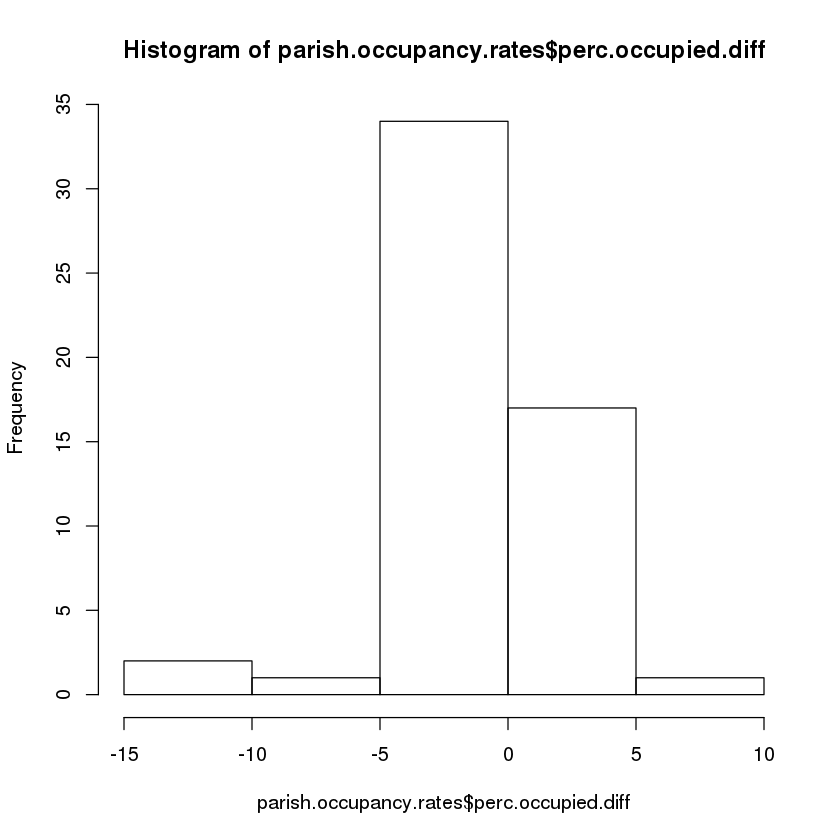

In [85]:
hist(parish.occupancy.rates$perc.occupied.diff)

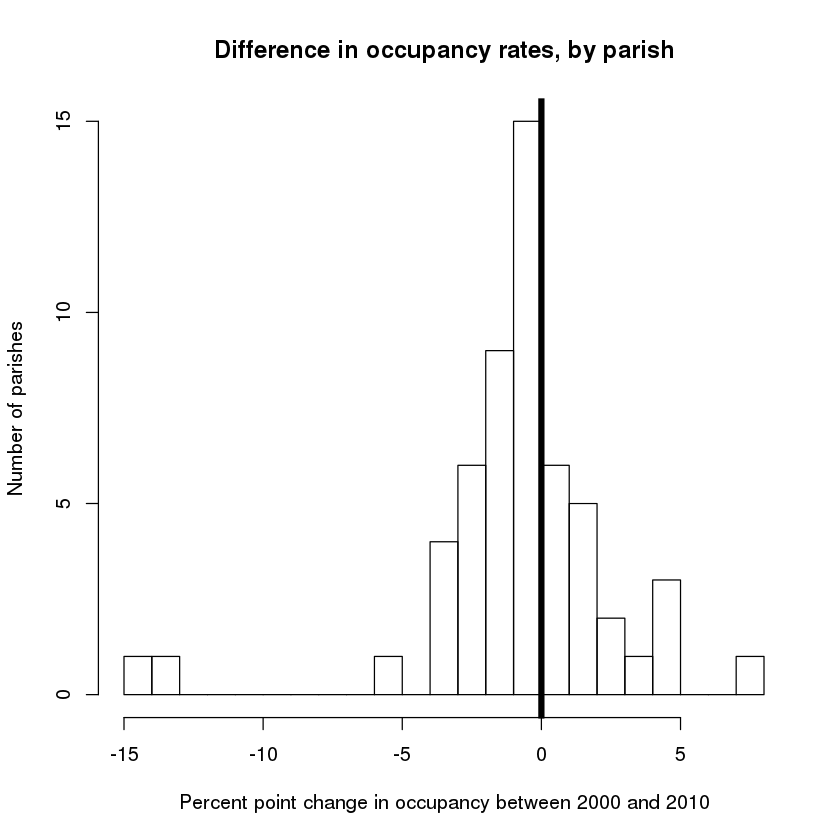

In [93]:
hist(parish.occupancy.rates$perc.occupied.diff, breaks = 20, main = 'Difference in occupancy rates, by parish',
    xlab = 'Percent point change in occupancy between 2000 and 2010', 
    ylab = 'Number of parishes'
    )
abline(v = 0, lwd = 5)